# COGS 108 - Final Project 

# Overview

In this project we analyzed youtube trending data over the course of six months to figure out what's the main factors for a videos' popularity. We did data scraping to acquired the lengths of the videos and data cleaning for removing dupilcates and invalide videos. We then used statiscal tools to determine the influence of different features on the popularity of a youtube video.

# Names

- Ziyi Ye
- Gaurav Tarun Parmar
- Wendy Li
- Ziyang Zhang
- Yiyun Zhang

# Group Members IDs

- A14684370
- A########
- A########
- A########
- A########

# Research Question

*Fill in your research question here*

## Background and Prior Work

*Fill in your background and prior work here* 

References (include links):
- 1)
- 2)

# Hypothesis


*Fill in your hypotheses here*

# Dataset(s)

*Fill in your dataset information here*

We used a relatively new dataset from a Kaggle challenge titled “Trending YouTube Video Statistics”, which contains features such as views, likes, dislikes, comments, tags and categories of the video. (https://www.kaggle.com/datasnaek/youtube-new). This dataset does not contain the length of the videos so we queried those from the youtub APIs.

(Copy this information for each dataset)
- Dataset Name:
- Link to the dataset:
- Number of observations:

1-2 sentences describing each dataset. 

If you plan to use multiple datasets, add 1-2 sentences about how you plan to combine these datasets.

# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import patsy
import statsmodels.api as sm
import seaborn as sns
import requests
import sys
import json
from scipy.stats import pearsonr
from datetime import datetime
import re
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from IPython.display import Image as Image_d

import nltk
import re
import operator
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy.stats import ttest_ind,normaltest
nltk.download('stopwords')
nltk.download('punkt')

# Data Cleaning

We first acquired the length of the videos using the youtube API. In the following cell, we turned the dataset on kaggle into a new length.csv file we contains three new columns: hour, min and sec all start with -1 indicating they have not been acquired yet.

In [2]:
"""
US_videos = pd.read_csv('./youtube-new/USvideos.csv')
row = US_videos.shape[0]
hour = np.repeat(-1, row)
min = np.repeat(-1, row)
sec = np.repeat(-1, row)

# -1 not scraped, 0 0 0 means not available
US_videos['hour'] = hour
US_videos['min'] = min
US_videos['sec'] = sec

US_videos.to_csv(r'length.csv', index=False, line_terminator='\r\n')
"""


"\nUS_videos = pd.read_csv('./youtube-new/USvideos.csv')\nrow = US_videos.shape[0]\nhour = np.repeat(-1, row)\nmin = np.repeat(-1, row)\nsec = np.repeat(-1, row)\n\n# -1 not scraped, 0 0 0 means not available\nUS_videos['hour'] = hour\nUS_videos['min'] = min\nUS_videos['sec'] = sec\n\nUS_videos.to_csv(r'length.csv', index=False, line_terminator='\r\n')\n"

The following function is used to query the youtube api with a video id and returns a string representation of the length of the video.

In [3]:
def get_length(video_id):
    searchUrl = "https://www.googleapis.com/youtube/v3/videos?id=" + \
        video_id+"&key="+api_key+"&part=contentDetails"

    request = requests.get(searchUrl)
    if request.status_code == 429:
        print("Temp-Banned due to excess requests, please wait and continue later")
        sys.exit()

    data = request.json()
    if 'items' not in data:
        print(data)
        return "Error"
    return data['items'][0]['contentDetails']['duration']

The following is the standardization function to standardize the string representation of the length the youtube API returns to a tuple of hour, minute and seconds. Youtube API returns a string in the format of "PT?H?M?S" but may not have all the characters H,M and S. For example, it may be "PT1H1S" if it's one hour and one seconds long.

In [4]:
def standardize_length(input):
    hour = 0
    min = 0
    sec = 0

    input = input.replace('PT', '')
    input = input.upper()
    if 'H' in input:
        hour = input.split('H')[0]
        input = input.split('H')[1]
    if 'M' in input:
        min = input.split('M')[0]
        input = input.split('M')[1]
    if 'S' in input:
        sec = input.split('S')[0]
        input = input.split('S')[1]
    return hour, min, sec

Since there's a daily quota limit to the youtube API we can use, the following cell in run multiple time over the course of a week with different api keys to fill in the lengths of the videos. Hour, minute and second are all set to zero if a video's length is not available. This may happen when the video is no longer available on youtube or it's a livestream video. Running the cell directly will cause an error since the api keys are not included in this directory.

In [5]:
"""
with open('./api_keys/YOURAPI.txt', 'r') as file:
    api_key = file.readline()

US_videos = pd.read_csv('./length.csv')
row = US_videos.shape[0]
hour = np.repeat(-1, row)
min = np.repeat(-1, row)
sec = np.repeat(-1, row)

# -1 not scraped, 0 0 0 means not available

unavailable_count = 0
dailyNum = 7000
startIndex = 0
first = True
stop = 0

# find start Index

for i, r in US_videos.iterrows():

    if r['hour'] == -1:
        startIndex = i
        break
    else:
        hour[i] = r['hour']
        min[i] = r['min']
        sec[i] = r['sec']


# startIndex = 0
print(startIndex)

for i, r in US_videos[startIndex: startIndex + dailyNum].iterrows():

    curr_id = r['video_id']

    # some videos are unavailable such as: n30k5CwLhS4
    try:

        if curr_id == '#NAME?' or curr_id == '#VALUE!':
            hour[i] = 0
            min[i] = 0
            sec[i] = 0
            unavailable_count += 1
            continue

        length = get_length(curr_id)

        if length == 'Error':
            print('stopping at: ', i)
            stop = i
            break

        hour[i], min[i], sec[i] = standardize_length(length)

        if i % 1000 == 0:
            print('saving ', startIndex, ' to ', i, 'to disk')
            US_videos['hour'] = hour
            US_videos['min'] = min
            US_videos['sec'] = sec
            US_videos.to_csv(r'length.csv', index=False,
                             line_terminator='\r\n')
    except IndexError:
        hour[i] = 0
        min[i] = 0
        sec[i] = 0
        unavailable_count += 1
    except:  # live stream videos
        hour[i] = 0
        min[i] = 0
        sec[i] = 0
        unavailable_count += 1
        print('unexpected error(possibly live stream video)')


print('unavailable videos', unavailable_count)

US_videos['hour'] = hour
US_videos['min'] = min
US_videos['sec'] = sec

if stop == 0:
    stop = startIndex + dailyNum
print(US_videos[stop - 5:stop + 5])
US_videos.to_csv(r'length.csv', index=False, line_terminator='\r\n')
"""

"\nwith open('./api_keys/YOURAPI.txt', 'r') as file:\n    api_key = file.readline()\n\nUS_videos = pd.read_csv('./length.csv')\nrow = US_videos.shape[0]\nhour = np.repeat(-1, row)\nmin = np.repeat(-1, row)\nsec = np.repeat(-1, row)\n\n# -1 not scraped, 0 0 0 means not available\n\nunavailable_count = 0\ndailyNum = 7000\nstartIndex = 0\nfirst = True\nstop = 0\n\n# find start Index\n\nfor i, r in US_videos.iterrows():\n\n    if r['hour'] == -1:\n        startIndex = i\n        break\n    else:\n        hour[i] = r['hour']\n        min[i] = r['min']\n        sec[i] = r['sec']\n\n\n# startIndex = 0\nprint(startIndex)\n\nfor i, r in US_videos[startIndex: startIndex + dailyNum].iterrows():\n\n    curr_id = r['video_id']\n\n    # some videos are unavailable such as: n30k5CwLhS4\n    try:\n\n        if curr_id == '#NAME?' or curr_id == '#VALUE!':\n            hour[i] = 0\n            min[i] = 0\n            sec[i] = 0\n            unavailable_count += 1\n            continue\n\n        length 

After acquiring all the lengths of the videos, we stored the data in "US_length.csv". We read that into a dataframe.

In [6]:
US_videos = pd.read_csv('US_length.csv')

US_videos.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,hour,min,sec
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,0,11,18
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",0,23,51
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,0,9,29
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,0,7,10
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,0,12,13


We get the length of titles and store those in a new column.

In [7]:
US_videos['title_length'] = US_videos['title'].str.len()
US_videos.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,hour,min,sec,title_length
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,0,11,18,34
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",0,23,51,62
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,0,9,29,53
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,0,7,10,32
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,0,12,13,24


One more thing we need to do is to transform the trending date to datetime format for plotting.

In [8]:
US_videos['trending_date'] = pd.to_datetime(US_videos['trending_date'], format='%y.%d.%m')

We then calculate the total number of seconds and store them in a new column and remove the hour, min and sec columns.

In [9]:
secs = US_videos['sec'].values
mins = US_videos['min'].values
hours = US_videos['hour'].values
total_time = [s+60*m+3600*h for s,m,h in zip(secs, mins, hours)]
US_videos['total_time'] = total_time
US_videos = US_videos.drop(['sec', 'min', 'hour'], axis = 1)

There are many duplicate videos since a video may be trending on multiple dates. We first remove the duplicate videos and keep only the video with the highest view count among those. We also save the original dataframe with duplicates in a separate dataframe to do further analysis.

In [150]:
# sorted_videos = US_videos.sort_values(['title_length', 'title']).set_index(['title_length', 'title'])
# sorted_videos.head()
duplicate = US_videos

In [11]:
uniq = US_videos['title'].unique()

df_extract = pd.DataFrame()
for i in uniq:
    cur_df = US_videos.loc[US_videos['title'] == i]
    max_view = max(cur_df['views'].tolist())
    cur_df = cur_df[cur_df.views == max_view]
    df_extract = df_extract.append(cur_df, sort=False,ignore_index=True)
US_videos = df_extract
print("Done removing duplicates")

Done removing duplicates


Now let's take a look at the cleaned dataframe.

In [12]:
US_videos.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,title_length,total_time
0,2kyS6SvSYSE,2017-11-20,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,2564903,96321,7972,22149,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,34,678
1,1ZAPwfrtAFY,2017-11-20,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",6109402,151250,11508,19820,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",62,1431
2,5qpjK5DgCt4,2017-11-20,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",5315471,187303,7278,9990,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,53,569
3,puqaWrEC7tY,2017-11-20,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",913268,16729,1386,2988,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,32,430
4,d380meD0W0M,2017-11-19,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2819118,153395,2416,20573,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,24,733


# Data Visualization

First we try to see how many trending videos per day are in this dataset. It can be seen that the dataset has about 200 videos per day to begin with, but after removing those duplicates, there are only less than half of the videos per day.

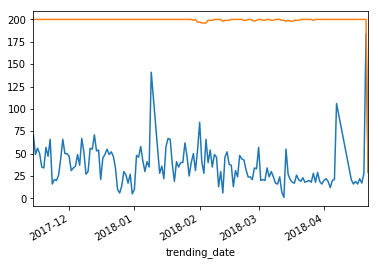

In [147]:
US_videos['trending_date'].groupby((US_videos["trending_date"])).count().plot()
duplicate['trending_date'].groupby((duplicate["trending_date"])).count().plot()

We plot the histogram of the total number of seconds.

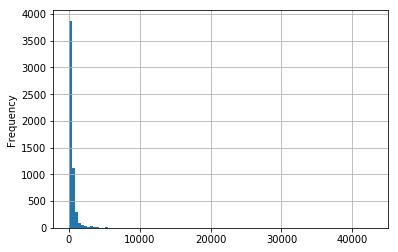

In [14]:
US_videos['total_time'].plot.hist(bins= 100,grid=True)

Many videos have nearly 0 lengths. Let's check how many videos have 0 second length, which means the length is not valid.

In [15]:
print(US_videos.shape[0])
print(US_videos[US_videos['total_time'] == 0].shape[0])

5567
340


It turns out that only less than 10 percent of the videos have 0 seconds length. The result in the previous graph is because some videos have very long lengths compared to other. Therefore we remove the videos with 0 lengths and do a log transformation of the lengths.

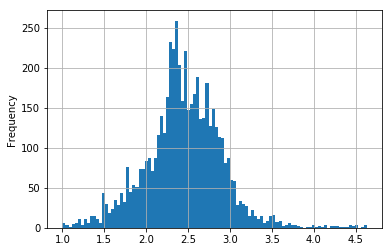

In [16]:
np.log10(US_videos[US_videos['total_time'] != 0]['total_time']).plot.hist(bins= 100,grid=True)

TODO: check normal distribution and write analysis

We check the number of videos with different title lengths and the result shows that videos with title lengths of around 40-60 characters are most common among trending videos.

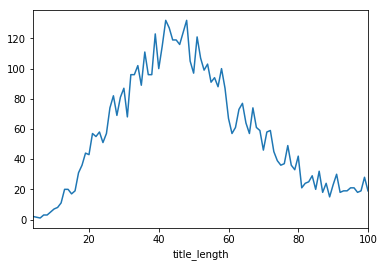

In [17]:
US_videos['title_length'].groupby(US_videos['title_length']).count().plot()

We then check the average lengths of videos each day and plot that length over time to see if there's trend. Here we are using the dataframe without removing the duplicates.

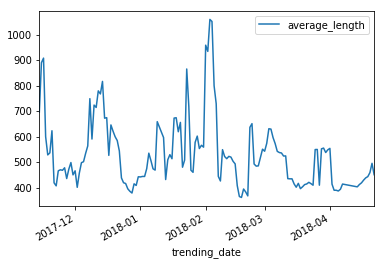

In [18]:
lengthOverTime = pd.DataFrame(index = duplicate['trending_date'].groupby((duplicatelicate['trending_date'])).count().index, columns =['average_length']) 
for date, r in lengthOverTime.iterrows():
    curr_length = duplicate[duplicate['trending_date'] == date]['total_time']
    curr_length = curr_length[curr_length != 0]
    average_length = sum(curr_length) /  curr_length.count()
    lengthOverTime['average_length'][date] = average_length
lengthOverTime.plot()


In [19]:
length_arr = lengthOverTime['average_length'].to_numpy()
r, p = pearsonr(length_arr.astype(np.float64), np.arange(0, np.size(length_arr)))
r,p

(-0.2724783650093921, 0.0006835316762581829)

As we can see, there's slight decreasing trend in the the average lengths over the six months. The decreasing rate is relatively small and there are fluctuations, but the small p-value indicates a statistically significant decreasing trend overtime.

TODO: say that we are using views as a measure of popularity in the following sections because of the correlation.

# Data Analysis & Results

In order to analyze the relationship between the popularity of a video (in this case we are using the views as an indicator), we create linear models to predict the views of a video from the length of the videos and the length of the title. 

We do a log transform of the views for a better scale. Also we are drop all the videos with zero lengths and store them in a new dataframe.

In [20]:
US_videos['logViews'] = np.log(US_videos['views'])
US_videos_valid_length = US_videos[US_videos['total_time'] != 0]

Here we do a regression of the popularity of videos with the length of the titles.

                            OLS Regression Results                            
Dep. Variable:               logViews   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     22.82
Date:                Fri, 06 Dec 2019   Prob (F-statistic):           1.82e-06
Time:                        20:46:56   Log-Likelihood:                -11265.
No. Observations:                5567   AIC:                         2.253e+04
Df Residuals:                    5565   BIC:                         2.255e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       13.0614      0.067    195.182   

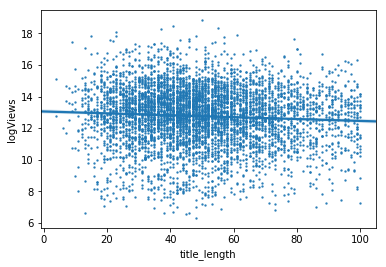

In [21]:
outcome, predictors = patsy.dmatrices('logViews ~ title_length', US_videos)

mod = sm.OLS(outcome, predictors)
res = mod.fit()

# Print out the summary results of the model fitting
print(res.summary())

sns.regplot(x='title_length', y='logViews', data=US_videos,scatter_kws={'s':2})

It turns out there's a statiscally significant negative relationship between the title length of the popularity, but this explains very little(0.005) of the difference in views.

We run a OLS regression on the log of the view counts and the lengths of the video.

                            OLS Regression Results                            
Dep. Variable:               logViews   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     7.685
Date:                Fri, 06 Dec 2019   Prob (F-statistic):            0.00559
Time:                        20:46:57   Log-Likelihood:                -10544.
No. Observations:                5227   AIC:                         2.109e+04
Df Residuals:                    5225   BIC:                         2.111e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.8010      0.026    487.723      0.0

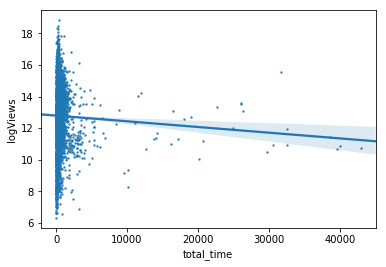

In [22]:
outcome, predictors = patsy.dmatrices('logViews ~ total_time', US_videos_valid_length)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())
sns.regplot(x='total_time', y='logViews', data=US_videos_valid_length,scatter_kws={'s':2})

It can be seen that there's a fairly significant negative relationship between the views and the lengths of the video (p-value is 0.6%), but the R-squared value is 0.001 so the lengths of the video explains very little for the difference in the views. 

There are some outliers in the graph that certainly skewed the regression. There are a couple very long videos. We removed the outliers videos and run the regression again.

                            OLS Regression Results                            
Dep. Variable:               logViews   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.682
Date:                Fri, 06 Dec 2019   Prob (F-statistic):              0.102
Time:                        20:46:58   Log-Likelihood:                -10421.
No. Observations:                5163   AIC:                         2.085e+04
Df Residuals:                    5161   BIC:                         2.086e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.7537      0.035    369.620      0.0

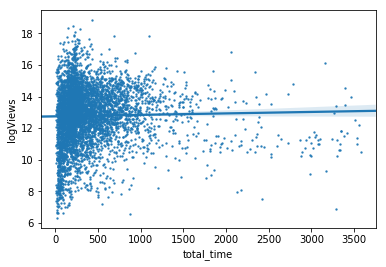

In [23]:
outcome, predictors = patsy.dmatrices('logViews ~ total_time', US_videos_valid_length[US_videos_valid_length['total_time'] < 3600])
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())
sns.regplot(x='total_time', y='logViews', data=US_videos_valid_length[US_videos_valid_length['total_time'] < 3600],scatter_kws={'s':2})

The regression model shown above is for all videos of length less than 3600 seconds (1 hour) and it turns out there's very little relationship between the length of the videos and the popularity in this regression.

                            OLS Regression Results                            
Dep. Variable:               logViews   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     118.5
Date:                Fri, 06 Dec 2019   Prob (F-statistic):           3.12e-27
Time:                        20:47:00   Log-Likelihood:                -8365.2
No. Observations:                4116   AIC:                         1.673e+04
Df Residuals:                    4114   BIC:                         1.675e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.2275      0.056    219.008      0.0

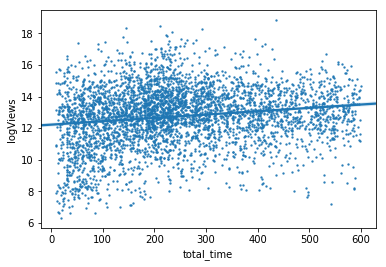

In [24]:
outcome, predictors = patsy.dmatrices('logViews ~ total_time', US_videos_valid_length[US_videos_valid_length['total_time'] < 600])
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())
sns.regplot(x='total_time', y='logViews', data=US_videos_valid_length[US_videos_valid_length['total_time'] < 600],scatter_kws={'s':2})

The regression model shown above is for all videos of length less than 600 seconds (10 minutes) and there's a statistically significant positive relationship between the views and the lengths of the videos. The R-square is still fairly small, so the lengths of the videos do not explain much about the difference of the popularity. 

We now dig deeper in the titles of these trending youtube videos. First we make a word cloud of the popular words that are used in the trending videos. //MIA TODO describe

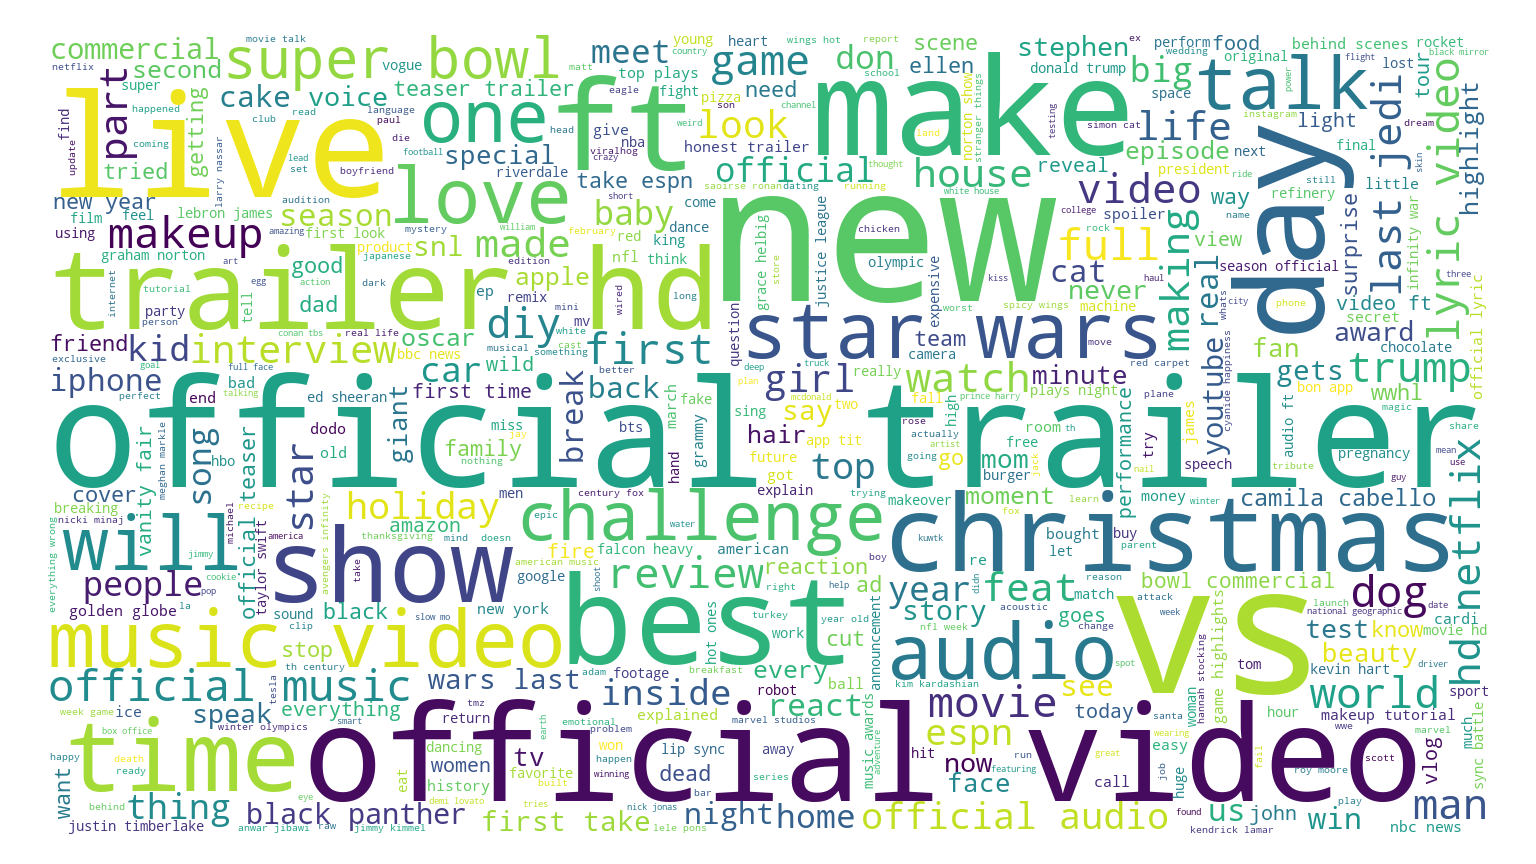

In [25]:
df = US_videos
titleLst = df['title'].tolist()

for i in range(len(titleLst)):
    new = re.sub(r"’", '', titleLst[i])
    titleLst[i] = re.sub(r'[^a-zA-Z_]', ' ', new)

with open('titles_non_repeating.txt', 'w') as f:
    for i in range(len(titleLst)):
        newLst = titleLst[i].split(" ")
        length = len(newLst)
        for y in range(length):
            if not (newLst[y] == " ") and not newLst[y] == "" and not len(newLst[y]) == 1:
                f.write(str(newLst[y] + ' '))

titleFile = open("titles_non_repeating.txt", "r").read()


def create_word_cloud(string):
    mask = np.array(Image.open("square.png"))
    cloud = WordCloud(background_color="white", max_words=500, mask=mask,
                      stopwords=set(STOPWORDS), collocations=True)
    cloud.generate(string)
    cloud.to_file("wordCloud_square_collocation500_new.png")


titleFile = titleFile.lower()
create_word_cloud(titleFile)

Image_d(filename='wordCloud_square_collocation500_new.png') 

We then find the most used 50 words and analyze whether using these words in the title affects the popularity of a video.

In [117]:
df = US_videos

title_list = df['title'].tolist()
title_dict = {}

for i in range(len(title_list)):
    stop_words = set(stopwords.words('english'))
    original = word_tokenize(title_list[i])
    filtered = []

    for j in original:
        lower = j.lower()
        lower = re.sub(r"’", '', lower)
        lower = re.sub(r'[^a-zA-Z_]', ' ', lower)
        if lower not in stop_words and len(lower) > 1 and not lower.isspace() \
                and not (" " in lower):
            filtered.append(lower)
        for w in filtered:
            if w not in title_dict:
                title_dict[w] = 1
            else:
                title_dict[w] += 1

sorted_dict = sorted(title_dict.items(), key=operator.itemgetter(1))
count = len(sorted_dict)
top = sorted_dict[count-50: count+1]
top_list = [i[0] for i in top]
print(top_list)


['kim', 'house', 'like', 'real', 'audio', 'makes', 'life', 'movie', 'cardi', 'making', 'jedi', 'show', 'year', 'diy', 'man', 'bowl', 'time', 'love', 'watch', 'feat', 'music', 'one', 'makeup', 'get', 'stephen', 'game', 'john', 'hd', 'vs', 'christmas', 'season', 'make', 'super', 'world', 'day', 'top', 'james', 'wars', 'last', 'black', 'full', 'trump', 'best', 'star', 'first', 'video', 'live', 'new', 'trailer', 'official']


We make two distributions of videos' views. top_d for those videos with titles that include the most used words and non_top for those that do not include these 50 words.

In [112]:
top_d = US_videos[US_videos['title'].str.contains('|'.join(top_list))]['views']
non_top_d = US_videos[~ US_videos['title'].str.contains('|'.join(top_list))]['views']
print('average views of videos that include the top 30 words:', top_d.mean())
print('average views of videos that do not include the top 30 words:', non_top_d.mean())

average views of videos that include the top 30 words: 979816.2245989305
average views of videos that do not include the top 30 words: 1570220.0578583765


The average views of those videos with popular words are actually less than those with not. We plot out the distribution on a log scale.

Text(0.5, 0, 'top')

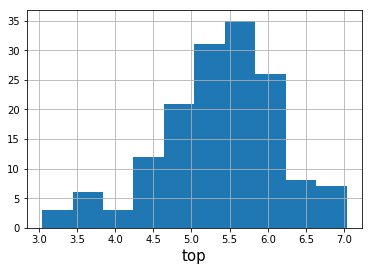

In [109]:
np.log10(top_d).hist()
plt.xlabel("top", fontsize=15)

Text(0.5, 0, 'non_top')

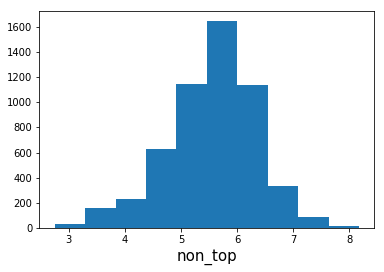

In [108]:
plt.hist(np.log10(non_top_d))
plt.xlabel("non_top", fontsize=15)

In [113]:
t_val, p_val = ttest_ind(top_d, non_top_d)
t_val, p_val

(-3.4343834643240876, 0.000598238899911018)

After running the t-test, we can see the difference is actually quite significant. This means that while certain words such as "official", "trailer" appear more frequently than other in trending videos, using these words is actually correlated with less views among all the trending videos.

We now try to determine the average video lengths and title lengths of the most popular videos. We first define popular videos as those with more then 10 million views.

In [134]:
popular_videos = US_videos[US_videos['views'] > 10000000]

We plot the distribution of the lengths of popular videos and determine the average lengths. We also test to see if the lengths are normally distributed.

average length of popular videos (in seconds): 303.4


NormaltestResult(statistic=175.7153509293746, pvalue=6.98065786323699e-39)

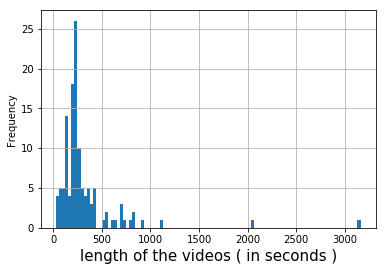

In [154]:
popular_videos[popular_videos['total_time'] != 0]['total_time'].plot.hist(bins= 100,grid=True)
plt.xlabel("length of the videos ( in seconds )", fontsize=15)
print('average length of popular videos (in seconds):', popular_videos['total_time'].mean())
normaltest(popular_videos['total_time'])

It turns out the distribution is not normally distributed. //TODO explain 
The average length of the videos is about 5 minutes.

We then plot the distribution of the title lengths of popular videos and determine the average lengths of the titles. We also test to see if the lengths are normally distributed.

average title length of popular videos (in number of characters): 44.16923076923077


NormaltestResult(statistic=12.796253046636602, pvalue=0.001664673079764679)

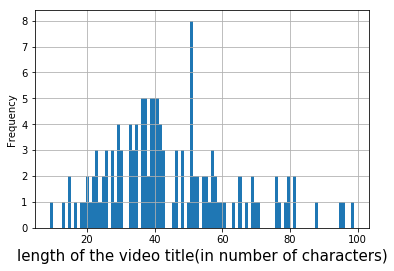

In [156]:
popular_videos['title_length'].plot.hist(bins= 100,grid=True)
plt.xlabel("length of the video title(in number of characters)", fontsize=15)
print('average title length of popular videos (in number of characters):', popular_videos['title_length'].mean())
normaltest(popular_videos['title_length'])

It turns out the distribution is not normally distributed. //TODO explain 
The average length of the videos is about 44 characters.

# Ethics & Privacy

*Fill in your ethics & privacy discussion here*

# Conclusion & Discussion

- among the six months, the average length of the trending videos tends to go shorter.
- title lengths and views don't matter that much.
    - don't be too long 
    - when the lengths is shorter than 10 minutes, there's actually positive relation
- words like official trailer make it to the trending list more, but among the trending list videos, they actually have fewer views.